In [11]:
from google.colab import drive
drive.mount('/content/drive')

import os
folder_path = '/content/drive/My Drive/GT/cs6220/Analysis/SAT' # Change the path to the folder where the assignment is stored in Google Drive.

# Files in the folder -
os.listdir(folder_path)

os.chdir(folder_path)

print('Current working directory -', os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory - /content/drive/My Drive/GT/cs6220/Analysis/SAT


In [3]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [8]:
llema_file_path = "llemma_math_sat_answers_2.csv"

mistral_file_path = "Mistral_Inference_SAT_Dataset.csv"

llama_file_path = "the_inference_llama3_sat_math.csv"

qwen_file_path = "inference_QWEN_sat_math.csv"

def extract_numbers(s):
    normalized = re.sub(r'[^\d\s]', '', s)
    return list(map(int, re.findall(r'\d+', normalized)))
def compare_number_lists(list1, list2):
    return set(list1).issubset(set(list2))  # list1=correct solution

In [5]:
import pandas as pd
from datasets import load_dataset, DatasetDict, Dataset
import matplotlib.pyplot as plt
import re


sat_math_dict = load_dataset("knazarali3/group2_processed_sat_math_cot")
train_dataset = sat_math_dict["train"]
test_dataset = sat_math_dict["test"]
test_dataset_df = pd.DataFrame(test_dataset)
test_dataset_df["row_index"] = test_dataset_df.index

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/706 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/3.64M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25158 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [6]:

def format_llema_inference_sat_math():
    df = pd.read_csv(llema_file_path, index_col=0)
    llema_test_dataset= df.merge(test_dataset_df, left_on='Question Id', right_on='id')

    llema_test_dataset['Correct Final Solution'] = llema_test_dataset['answer'].apply(extract_numbers)

    llema_test_dataset["llema_is_correct"] = llema_test_dataset.apply(
        lambda row: row["Final Solution"] in row["Correct Final Solution"], axis=1
    )

    llema_test_dataset = llema_test_dataset.rename(columns={"Final Solution": "llema_solution"})

    llema_3_results = llema_test_dataset[["Question Id", "llema_is_correct", "llema_solution"]]
    return llema_3_results


def format_mistral_inference_sat_math():
    df = pd.read_csv(mistral_file_path)
    mistral_test_dataset= df.merge(test_dataset_df, left_on='ID', right_on='id')

    mistral_test_dataset['Final Solution Numbers'] = mistral_test_dataset['answer'].apply(extract_numbers)


    mistral_test_dataset['Run_1'] = mistral_test_dataset['Run_1'].astype(str)

    mistral_test_dataset['Mistral Model Solution Numbers'] = mistral_test_dataset['Run_1'].apply(extract_numbers)

    mistral_test_dataset['mistral_is_correct'] = [
        compare_number_lists(a, b) for a, b in zip(mistral_test_dataset['Final Solution Numbers'], mistral_test_dataset['Mistral Model Solution Numbers'])
    ]

    mistral_test_dataset = mistral_test_dataset.rename(columns={"ID": "Question Id"})

    mistral_results = mistral_test_dataset[["Question Id", "mistral_is_correct", "Mistral Model Solution Numbers"]]
    return mistral_results

def format_llama_inference_sat_math():
    df = pd.read_csv(llama_file_path)
    llama_test_dataset= df.merge(test_dataset_df, left_on='ID', right_on='id')

    llama_test_dataset['Final Solution Numbers'] = llama_test_dataset['answer'].apply(extract_numbers)

    llama_test_dataset['Run_1'] = llama_test_dataset['Run_1'].astype(str)

    llama_test_dataset['Llama Model Solution Numbers'] = llama_test_dataset['Run_1'].apply(extract_numbers)

    llama_test_dataset['llama_is_correct'] = [
        compare_number_lists(a, b) for a, b in zip(llama_test_dataset['Final Solution Numbers'], llama_test_dataset['Llama Model Solution Numbers'])
    ]

    llama_test_dataset = llama_test_dataset.rename(columns={"ID": "Question Id"})

    llama_results = llama_test_dataset[["Question Id", "llama_is_correct", "Llama Model Solution Numbers"]]
    return llama_results

def format_qwen_inference_sat_math():
    df = pd.read_csv(qwen_file_path)
    qwen_test_dataset= df.merge(test_dataset_df, left_on='row_index', right_on='row_index')


    qwen_test_dataset['Final Solution Numbers'] = qwen_test_dataset['answer'].apply(extract_numbers)

    qwen_test_dataset['Run_1'] = qwen_test_dataset['Run_1'].astype(str)

    qwen_test_dataset['Qwen Model Solution Numbers'] = qwen_test_dataset['Run_1'].apply(extract_numbers)

    qwen_test_dataset['qwen_is_correct'] = [
        compare_number_lists(a, b) for a, b in zip(qwen_test_dataset['Final Solution Numbers'], qwen_test_dataset['Qwen Model Solution Numbers'])
    ]

    qwen_test_dataset = qwen_test_dataset.rename(columns={"id": "Question Id"})

    qwen_results = qwen_test_dataset[["Question Id", "qwen_is_correct", "Qwen Model Solution Numbers"]]

    return qwen_results

In [12]:

print('Files -', os.listdir())

Files - ['analysis_sat_math_kiran.ipynb', 'Mistral_Inference_SAT_Dataset.csv', 'llemma_math_sat_answers_2.csv', 'inference_QWEN_sat_math.csv', 'the_inference_llama3_sat_math.csv', 'llemma_math_sat_answers.txt']


In [13]:
llama_results = format_llama_inference_sat_math()
llema_results = format_llema_inference_sat_math()
qwen_results = format_qwen_inference_sat_math()
mistral_results = format_mistral_inference_sat_math()

# Check where all the answers correct column is True
# i.e. all models got the answer correct
all_results = ((llama_results.merge(llema_results)).merge(qwen_results)).merge(mistral_results)
all_results["all_correct"] = (all_results["llama_is_correct"] == True) & (all_results["llema_is_correct"] == True) & (all_results["qwen_is_correct"] == True) & (all_results["mistral_is_correct"]==True)

all_results["all_correct"].value_counts()

,count
all_correct,
False,6042
True,152


In [14]:
llama_results["llama_is_correct"].value_counts()

,count
llama_is_correct,
True,3862
False,2428


In [15]:
llema_results["llema_is_correct"].value_counts()

,count
llema_is_correct,
False,5354
True,936


In [16]:
qwen_results["qwen_is_correct"].value_counts()

,count
qwen_is_correct,
False,3156
True,3134


In [17]:
mistral_results["mistral_is_correct"].value_counts()

,count
mistral_is_correct,
False,5168
True,1026


In [34]:
import pandas as pd
from datasets import load_dataset, DatasetDict, Dataset
import matplotlib.pyplot as plt
import numpy as np

sat_math_dict = load_dataset("knazarali3/group2_processed_sat_math_cot")
test_dataset = sat_math_dict["test"]
test_dataset_df = pd.DataFrame(test_dataset)
test_dataset_df["row_index"] = test_dataset_df.index

def format_llema_inference_sat_math():
    df = pd.read_csv(llema_file_path, index_col=0)
    llema_test_dataset = df.merge(test_dataset_df, left_on='Question Id', right_on='id')

    llema_test_dataset['Correct Final Solution'] = llema_test_dataset['answer'].apply(extract_numbers)
    llema_test_dataset["llema_is_correct"] = llema_test_dataset.apply(
        lambda row: row["Final Solution"] in row["Correct Final Solution"], axis=1
    )

    llema_test_dataset = llema_test_dataset.rename(columns={"Final Solution": "llema_solution"})

    llema_3_results = llema_test_dataset[["Question Id", "row_index", "llema_is_correct", "llema_solution"]]
    return llema_3_results

def format_mistral_inference_sat_math():
    df = pd.read_csv(mistral_file_path)
    mistral_test_dataset = df.merge(test_dataset_df, left_on='row_index', right_on='row_index')

    mistral_test_dataset['Final Solution Numbers'] = mistral_test_dataset['answer'].apply(extract_numbers)
    mistral_test_dataset['Run_1'] = mistral_test_dataset['Run_1'].astype(str)
    mistral_test_dataset['Mistral Model Solution Numbers'] = mistral_test_dataset['Run_1'].apply(extract_numbers)

    mistral_test_dataset['mistral_is_correct'] = [
        compare_number_lists(a, b) for a, b in zip(mistral_test_dataset['Final Solution Numbers'],
                                                 mistral_test_dataset['Mistral Model Solution Numbers'])
    ]

    mistral_test_dataset = mistral_test_dataset.rename(columns={"ID": "Question Id"})

    # Now include row_index in the output since we got it from the merge
    mistral_results = mistral_test_dataset[["Question Id", "row_index", "mistral_is_correct", "Mistral Model Solution Numbers"]]
    return mistral_results

def format_llama_inference_sat_math():
    df = pd.read_csv(llama_file_path)
    llama_test_dataset = df.merge(test_dataset_df, left_on='ID', right_on='id')

    llama_test_dataset['Final Solution Numbers'] = llama_test_dataset['answer'].apply(extract_numbers)
    llama_test_dataset['Run_1'] = llama_test_dataset['Run_1'].astype(str)
    llama_test_dataset['Llama Model Solution Numbers'] = llama_test_dataset['Run_1'].apply(extract_numbers)

    llama_test_dataset['llama_is_correct'] = [
        compare_number_lists(a, b) for a, b in zip(llama_test_dataset['Final Solution Numbers'],
                                                 llama_test_dataset['Llama Model Solution Numbers'])
    ]

    llama_test_dataset = llama_test_dataset.rename(columns={"ID": "Question Id"})

    llama_results = llama_test_dataset[["Question Id", "row_index", "llama_is_correct", "Llama Model Solution Numbers"]]
    return llama_results

def format_qwen_inference_sat_math():
    df = pd.read_csv(qwen_file_path)
    qwen_test_dataset = df.merge(test_dataset_df, left_on='row_index', right_on='row_index')

    qwen_test_dataset['Final Solution Numbers'] = qwen_test_dataset['answer'].apply(extract_numbers)
    qwen_test_dataset['Run_1'] = qwen_test_dataset['Run_1'].astype(str)
    qwen_test_dataset['Qwen Model Solution Numbers'] = qwen_test_dataset['Run_1'].apply(extract_numbers)

    qwen_test_dataset['qwen_is_correct'] = [
        compare_number_lists(a, b) for a, b in zip(qwen_test_dataset['Final Solution Numbers'],
                                                qwen_test_dataset['Qwen Model Solution Numbers'])
    ]

    qwen_test_dataset = qwen_test_dataset.rename(columns={"id": "Question Id"})

    qwen_results = qwen_test_dataset[["Question Id", "row_index", "qwen_is_correct", "Qwen Model Solution Numbers"]]
    return qwen_results

In [37]:
llama3_results = format_llama_inference_sat_math()
llema_results = format_llema_inference_sat_math()
qwen_results = format_qwen_inference_sat_math()
mistral_results = format_mistral_inference_sat_math()

# Check where all the answers correct column is True
# i.e. all models got the answer correct
all_results = ((llama3_results.merge(llema_results)).merge(qwen_results)).merge(mistral_results)
all_results["all_correct"] = (all_results["llama_is_correct"] == True) & (all_results["llema_is_correct"] == True) & (all_results["qwen_is_correct"] == True) & (all_results["mistral_is_correct"]==True)

all_results["all_incorrect"] = (all_results["llama_is_correct"] == False) & (all_results["llema_is_correct"] == False) & (all_results["qwen_is_correct"] == False) & (all_results["mistral_is_correct"]==False)

all_results["at_least_3_correct"] = (
    all_results[["llama_is_correct", "llema_is_correct", "qwen_is_correct", "mistral_is_correct"]]
    .sum(axis=1) >= 3
)
all_results["at_least_2_correct"] = (
    all_results[["llama_is_correct", "llema_is_correct", "qwen_is_correct", "mistral_is_correct"]]
    .sum(axis=1) >= 2
)

all_results["at_least_1_correct"] = (
    all_results[["llama_is_correct", "llema_is_correct", "qwen_is_correct", "mistral_is_correct"]]
    .sum(axis=1) >= 1
)


# Check wehere all answers solution column have the same answer
# i.e. all models got the same answer
all_results["all_agree"] = (
    (all_results["llema_solution"] == all_results["Llama Model Solution Numbers"]) &
    (all_results["Qwen Model Solution Numbers"] == all_results["Llama Model Solution Numbers"]) &
    (all_results["Mistral Model Solution Numbers"] == all_results["Llama Model Solution Numbers"]) &
    (all_results["llema_solution"] != "Error Parsing Response")
)

In [38]:
all_results["at_least_3_correct"].value_counts()


,count
at_least_3_correct,
False,5132
True,1062


In [60]:
def give_ensemble_model_atleast1_piechart():

    ensemble_model_atleast1_correct = pd.DataFrame( all_results['at_least_1_correct'].value_counts() )

    labels = ['Other', 'At least 1 Model Correct']
    sizes = [ ensemble_model_atleast1_correct['count'].iloc[0],ensemble_model_atleast1_correct['count'].iloc[1]]
    colors = ['#00ff00', '#ff9999']

    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
    plt.axis('equal')
    plt.legend()
    plt.title(' Questions That At Least 1 Model Gave Correct Answers')

    return plt


def give_ensemble_model_atleast2_piechart():

    ensemble_model_atleast2_correct = pd.DataFrame( all_results['at_least_2_correct'].value_counts() )

    labels = ['Other', 'At least 2 Model Correct']
    sizes = [ ensemble_model_atleast2_correct['count'].iloc[0],ensemble_model_atleast2_correct['count'].iloc[1]]
    colors = ['#ff9999', '#00ff00']

    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
    plt.axis('equal')
    plt.legend()
    plt.title(' Questions That At Least 2 Models Gave Correct Answers')

    return plt


def give_ensemble_model_atleast3_piechart():

    ensemble_model_atleast3_correct = pd.DataFrame( all_results['at_least_3_correct'].value_counts() )

    labels = ['Other', 'At least 3 Model Correct']
    sizes = [ ensemble_model_atleast3_correct['count'].iloc[0],ensemble_model_atleast3_correct['count'].iloc[1]]
    colors = ['#ff9999', '#00ff00']

    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
    plt.axis('equal')
    plt.legend()
    plt.title(' Questions That At Least 3 Models Gave Correct Answers')

    return plt


def give_ensemble_model_all_incorrect_piechart():

    ensemble_model_all_incorrect = pd.DataFrame( all_results['all_incorrect'].value_counts() )

    labels = ['Other', 'All Incorrect']
    sizes = [ ensemble_model_all_incorrect['count'].iloc[0],ensemble_model_all_incorrect['count'].iloc[1]]
    colors = ['#66b3ff', '#ff9999']

    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
    plt.axis('equal')
    plt.legend()
    plt.title(' Questions That All Models Gave Incorrect Answers')

    return plt




def give_ensemble_model_all_correct_piechart():

    ensemble_model_all_correct = pd.DataFrame( all_results['all_correct'].value_counts() )

    labels = ['Other', 'All Correct']
    sizes = [ ensemble_model_all_correct['count'].iloc[0],ensemble_model_all_correct['count'].iloc[1]]
    colors = ['#ff9999', '#00ff00']

    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
    plt.axis('equal')
    plt.legend()
    plt.title(' Questions That All Models Gave Correct Answers')

    return plt


def give_ensemble_model_all_agree_piechart():

    ensemble_model_all_agree = pd.DataFrame(all_results["all_agree"].value_counts())

    labels = ['Agree', 'Disagree']
    sizes = [ ensemble_model_all_agree['count'].iloc[0],ensemble_model_all_agree['count'].iloc[1]]
    colors = ['#ff9999', '#66b3ff']

    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
    plt.axis('equal')
    plt.legend()
    plt.title(' Questions That All Models Agreed on vs Disagreed on Answer')

    return plt



In [ ]:
# give_ensemble_model_all_correct_piechart().show()
# give_ensemble_model_all_incorrect_piechart().show()
# give_ensemble_model_atleast1_piechart().show()
# give_ensemble_model_atleast2_piechart().show()
# give_ensemble_model_atleast3_piechart().show()

In [64]:
def sample_correct_problems_with_solutions(all_results, test_dataset_df, num_samples=5):
    """
    Sample problems that all models answered correctly and show their solutions

    Parameters:
    all_results: DataFrame containing results from all models
    test_dataset_df: Original test dataset with problem details
    num_samples: Number of problems to sample (default 5)

    Returns:
    DataFrame containing sampled problems and all models' solutions
    """
    # Get problems where all models were correct
    correct_problems = all_results[all_results['all_correct'] == True]

    # Get the question IDs
    correct_question_ids = correct_problems['Question Id'].unique()

    # Sample random question IDs
    sampled_ids = random.sample(list(correct_question_ids), min(num_samples, len(correct_question_ids)))

    # Get the full problem details from the test dataset
    sampled_problems = test_dataset_df[test_dataset_df['id'].isin(sampled_ids)]

    # Get the model solutions for these problems
    model_solutions = all_results[all_results['Question Id'].isin(sampled_ids)]

    # Combine problem details with model solutions
    result = pd.merge(
        sampled_problems[['id', 'question', 'answer']],
        model_solutions[[
            'Question Id',
            'Llama Model Solution Numbers',
            'llema_solution',
            'Qwen Model Solution Numbers',
            'Mistral Model Solution Numbers'
        ]],
        left_on='id',
        right_on='Question Id'
    )

    # Clean up the display
    result = result.drop('Question Id', axis=1)
    result = result.rename(columns={
        'id': 'Problem ID',
        'question': 'Question',
        'answer': 'Correct Answer',
        'Llama Model Solution Numbers': 'Llama Solution',
        'llema_solution': 'Llema Solution',
        'Qwen Model Solution Numbers': 'Qwen Solution',
        'Mistral Model Solution Numbers': 'Mistral Solution'
    })

    return result


In [66]:
# Get 5 sample problems (or fewer if there aren't 5 available)
correct_samples = sample_correct_problems_with_solutions(all_results, test_dataset_df)

# Display the results
print("Sample Problems All Models Answered Correctly:")
pd.set_option('display.max_colwidth', None)  # To show full question text
display(correct_samples)

Sample Problems All Models Answered Correctly:


,Problem ID,Question,Correct Answer,Llama Solution,Llema Solution,Qwen Solution,Mistral Solution
0,25675,"Lidia has a collection of books. Her collection is four times bigger than the collection which her friend Susan has. In total Susan and Lidia, both have 3000 books. How many books does Susan have in her collection?",Susan has 600 books in her collection.,[600],600.0,[600],[600]
1,17239,"George was selling some of his old toys on the internet. He managed to sell 3 little cars and a set of Legos. In total, he earned $45. How much did the Legos set cost, if one little car was sold for $5?",The Lego set cost $30.,[30],30.0,[30],[30]
2,6122,"If the base of a parallelogram that has an area of 24 square centimeters (cm2) is 4 centimeters (cm), find the difference between the height and the length of the base.",The difference between the height and the length of the base is 2 cm.,[2],2.0,[2],[2]
3,19259,Nina enjoys keeping insects as pets. She has 3 spiders and 50 ants. Each spider has 8 eyes. Each ant has 2 eyes. How many eyes are there in total among Nina’s pet insects?,There are 124 eyes in total among Nina's pet insects.,[124],124.0,[124],[124]
4,4729,"Hoseok did 8 workouts on Monday, 5 on Tuesday, 12 on Wednesday, 17 on Thursday, and 10 on Friday. Find the number of times he worked out on Thursday minus the number of times he worked out on Tuesday.",Hoseok worked out 12 more times on Thursday than on Tuesday.,[12],12.0,[12],[12]


In [69]:
import pandas as pd
import random

def sample_three_correct_problems(all_results, test_dataset_df, num_samples=5):
    """
    Sample problems where exactly three models answered correctly

    Parameters:
    all_results: DataFrame containing results from all models
    test_dataset_df: Original test dataset with problem details
    num_samples: Number of problems to sample (default 5)

    Returns:
    DataFrame containing sampled problems and each model's solution
    """
    # Calculate how many models got each problem correct
    all_results['num_correct'] = (
        all_results['llama_is_correct'].astype(int) +
        all_results['llema_is_correct'].astype(int) +
        all_results['qwen_is_correct'].astype(int) +
        all_results['mistral_is_correct'].astype(int)
    )

    # Get problems where exactly three models were correct
    three_correct = all_results[all_results['num_correct'] == 3]

    # Get the question IDs
    three_correct_ids = three_correct['Question Id'].unique()

    # Sample random question IDs
    sampled_ids = random.sample(list(three_correct_ids), min(num_samples, len(three_correct_ids)))

    # Get the full problem details from the test dataset
    sampled_problems = test_dataset_df[test_dataset_df['id'].isin(sampled_ids)]

    # Get the model solutions for these problems
    model_solutions = all_results[all_results['Question Id'].isin(sampled_ids)]

    # Combine problem details with model solutions
    result = pd.merge(
        sampled_problems[['id', 'question', 'answer']],
        model_solutions[[
            'Question Id',
            'Llama Model Solution Numbers',
            'llema_solution',
            'Qwen Model Solution Numbers',
            'Mistral Model Solution Numbers',
            'llama_is_correct',
            'llema_is_correct',
            'qwen_is_correct',
            'mistral_is_correct'
        ]],
        left_on='id',
        right_on='Question Id'
    )

    # Clean up the display
    result = result.drop('Question Id', axis=1)
    result = result.rename(columns={
        'id': 'Problem ID',
        'question': 'Question',
        'answer': 'Correct Answer',
        'Llama Model Solution Numbers': 'Llama Solution',
        'llema_solution': 'Llema Solution',
        'Qwen Model Solution Numbers': 'Qwen Solution',
        'Mistral Model Solution Numbers': 'Mistral Solution',
        'llama_is_correct': 'Llama Correct',
        'llema_is_correct': 'Llema Correct',
        'qwen_is_correct': 'Qwen Correct',
        'mistral_is_correct': 'Mistral Correct'
    })

    # Add indicators for correct/incorrect solutions
    for model in ['Llama', 'Llema', 'Qwen', 'Mistral']:
        result[f'{model} Solution'] = result.apply(
            lambda x: f"{x[f'{model} Solution']} {'✓' if x[f'{model} Correct'] else '✗'}",
            axis=1
        )

    # Drop the separate correctness columns
    result = result.drop([
        'Llama Correct', 'Llema Correct',
        'Qwen Correct', 'Mistral Correct'
    ], axis=1)

    return result

In [71]:
# Get 5 sample problems where at least 3 models were correct
three_correct_samples = sample_three_correct_problems(all_results, test_dataset_df)

# Display the results
print("Sample Problems where at least 3 models answered correctly:")
pd.set_option('display.max_colwidth', None)  # To show full question text
display(three_correct_samples)

Sample Problems where at least 3 models answered correctly:


,Problem ID,Question,Correct Answer,Llama Solution,Llema Solution,Qwen Solution,Mistral Solution
0,18849,"At a pool party, there are 4 pizzas cut into 12 slices each. If the guests eat some slices and there are 9 slices left, how many slices did the guests eat?",The guests ate 39 slices of pizza.,[39] ✓,3.0 ✗,[39] ✓,[39] ✓
1,27546,"A vehicle is driven some miles on Monday, 18 miles on Tuesday, and 21 miles on Wednesday. The average distance traveled per day is 17 miles. How many miles were driven on Monday?",12 miles were driven on Monday.,[12] ✓,nan ✗,[12] ✓,[12] ✓
2,1821,"There are 30 trees along the straight road. If the distance between every tree is 3 meters (m), what is the distance between the first and the last trees?",The distance between the first and the last trees is 87 meters.,[87] ✓,90.0 ✗,[87] ✓,[87] ✓
3,28890,Nadine collected different colored pebbles. She has 20 white pebbles and some red pebbles. She has 30 pebbles in all. What is the ratio of the number of red pebbles to the number of white pebbles?,The ratio of the number of red pebbles to the number of white pebbles is 1:2.,[12] ✓,nan ✗,[12] ✓,[12] ✓
4,22752,"Kim has some nail polishes. Heidi has 5 more nail polishes than Kim, and Karen has 4 fewer nail polishes than Kim. Karen and Heidi have together 25 nail polishes. How many nail polishes does Kim have?",Kim has 12 nail polishes.,[12] ✓,14.0 ✗,[12] ✓,[12] ✓


In [72]:
import pandas as pd
import random

def sample_two_correct_problems(all_results, test_dataset_df, num_samples=5):
    """
    Sample problems where exactly two models answered correctly

    Parameters:
    all_results: DataFrame containing results from all models
    test_dataset_df: Original test dataset with problem details
    num_samples: Number of problems to sample (default 5)

    Returns:
    DataFrame containing sampled problems and each model's solution
    """
    # Calculate how many models got each problem correct
    all_results['num_correct'] = (
        all_results['llama_is_correct'].astype(int) +
        all_results['llema_is_correct'].astype(int) +
        all_results['qwen_is_correct'].astype(int) +
        all_results['mistral_is_correct'].astype(int)
    )

    # Get problems where exactly two models were correct
    two_correct = all_results[all_results['num_correct'] == 2]

    # Get the question IDs
    two_correct_ids = two_correct['Question Id'].unique()

    # Sample random question IDs
    sampled_ids = random.sample(list(two_correct_ids), min(num_samples, len(two_correct_ids)))

    # Get the full problem details from the test dataset
    sampled_problems = test_dataset_df[test_dataset_df['id'].isin(sampled_ids)]

    # Get the model solutions for these problems
    model_solutions = all_results[all_results['Question Id'].isin(sampled_ids)]

    # Combine problem details with model solutions
    result = pd.merge(
        sampled_problems[['id', 'question', 'answer']],
        model_solutions[[
            'Question Id',
            'Llama Model Solution Numbers',
            'llema_solution',
            'Qwen Model Solution Numbers',
            'Mistral Model Solution Numbers',
            'llama_is_correct',
            'llema_is_correct',
            'qwen_is_correct',
            'mistral_is_correct'
        ]],
        left_on='id',
        right_on='Question Id'
    )

    # Clean up the display
    result = result.drop('Question Id', axis=1)
    result = result.rename(columns={
        'id': 'Problem ID',
        'question': 'Question',
        'answer': 'Correct Answer',
        'Llama Model Solution Numbers': 'Llama Solution',
        'llema_solution': 'Llema Solution',
        'Qwen Model Solution Numbers': 'Qwen Solution',
        'Mistral Model Solution Numbers': 'Mistral Solution',
        'llama_is_correct': 'Llama Correct',
        'llema_is_correct': 'Llema Correct',
        'qwen_is_correct': 'Qwen Correct',
        'mistral_is_correct': 'Mistral Correct'
    })

    # Add indicators for correct/incorrect solutions
    for model in ['Llama', 'Llema', 'Qwen', 'Mistral']:
        result[f'{model} Solution'] = result.apply(
            lambda x: f"{x[f'{model} Solution']} {'✓' if x[f'{model} Correct'] else '✗'}",
            axis=1
        )

    # Drop the separate correctness columns
    result = result.drop([
        'Llama Correct', 'Llema Correct',
        'Qwen Correct', 'Mistral Correct'
    ], axis=1)

    return result

In [73]:
# Get 5 sample problems where exactly two models were correct
two_correct_samples = sample_two_correct_problems(all_results, test_dataset_df)

# Display the results
print("Sample Problems Where Exactly Two Models Were Correct:")
pd.set_option('display.max_colwidth', None)  # To show full question text
display(two_correct_samples)

Sample Problems Where Exactly Two Models Were Correct:


,Problem ID,Question,Correct Answer,Llama Solution,Llema Solution,Qwen Solution,Mistral Solution
0,27590,"Jack bought an ice cream cone before jogging to the beach. The ice cream cone will melt in some time, the beach is 16 blocks away, and each block is 1/8th of a mile. Jack needs to jog at a speed of 12 miles per hour to get to the beach before the ice cream melts. How long will the ice cream cone last before it melts?",The ice cream cone will last 10 minutes before it melts.,[10] ✓,10.0 ✓,[80] ✗,[100] ✗
1,19412,"Jude bought three chairs for his house, all at the same price. He also bought a table that costs $50 and two sets of plates at $20 for each set. After giving the cashier $130, Jude got a $4 change. How much did each of the chairs cost?",Each chair cost $12.,[12] ✓,18.0 ✗,[12] ✓,[] ✗
2,24929,"Patty's dress was $10 more than Ida's dress, and Ida's dress was $30 more than Jean's dress, and Jean's dress was $10 less than Pauline's dress, and lastly Pauline's dress was some amount. All the ladies spent $160 on dresses put together. How much did Pauline's dress cost?",Pauline's dress cost $30.,[30] ✓,nan ✗,[30] ✓,[40] ✗
3,11624,"Henry has 30 more lollipops than Alison does. With 60 lollipops, Alisson has half the number of lollipops Diane has. If they combine the lollipops and eat a certain number of lollipops each day, it will take them a total of 6 days to finish the lollipops. How many lollipops do they eat each day?",They eat 45 lollipops each day.,[45] ✓,nan ✗,[45] ✓,[15] ✗
4,9672,"Jenny had some money and spent a fraction of it. She had $24 left after spending that portion, and half of her original amount of money is $21. What fraction of her money did she spend?",Jenny spent 3/7 of her money.,[37] ✓,nan ✗,[37] ✓,[] ✗


In [74]:
import pandas as pd
import random

def sample_one_correct_problems(all_results, test_dataset_df, num_samples=5):
    """
    Sample problems where exactly one model answered correctly

    Parameters:
    all_results: DataFrame containing results from all models
    test_dataset_df: Original test dataset with problem details
    num_samples: Number of problems to sample (default 5)

    Returns:
    DataFrame containing sampled problems and each model's solution
    """
    # Calculate how many models got each problem correct
    all_results['num_correct'] = (
        all_results['llama_is_correct'].astype(int) +
        all_results['llema_is_correct'].astype(int) +
        all_results['qwen_is_correct'].astype(int) +
        all_results['mistral_is_correct'].astype(int)
    )

    # Get problems where exactly one model was correct
    one_correct = all_results[all_results['num_correct'] == 1]

    # Get the question IDs
    one_correct_ids = one_correct['Question Id'].unique()

    # Sample random question IDs
    sampled_ids = random.sample(list(one_correct_ids), min(num_samples, len(one_correct_ids)))

    # Get the full problem details from the test dataset
    sampled_problems = test_dataset_df[test_dataset_df['id'].isin(sampled_ids)]

    # Get the model solutions for these problems
    model_solutions = all_results[all_results['Question Id'].isin(sampled_ids)]

    # Combine problem details with model solutions
    result = pd.merge(
        sampled_problems[['id', 'question', 'answer']],
        model_solutions[[
            'Question Id',
            'Llama Model Solution Numbers',
            'llema_solution',
            'Qwen Model Solution Numbers',
            'Mistral Model Solution Numbers',
            'llama_is_correct',
            'llema_is_correct',
            'qwen_is_correct',
            'mistral_is_correct'
        ]],
        left_on='id',
        right_on='Question Id'
    )

    # Clean up the display
    result = result.drop('Question Id', axis=1)
    result = result.rename(columns={
        'id': 'Problem ID',
        'question': 'Question',
        'answer': 'Correct Answer',
        'Llama Model Solution Numbers': 'Llama Solution',
        'llema_solution': 'Llema Solution',
        'Qwen Model Solution Numbers': 'Qwen Solution',
        'Mistral Model Solution Numbers': 'Mistral Solution',
        'llama_is_correct': 'Llama Correct',
        'llema_is_correct': 'Llema Correct',
        'qwen_is_correct': 'Qwen Correct',
        'mistral_is_correct': 'Mistral Correct'
    })

    # Add indicators for correct/incorrect solutions
    for model in ['Llama', 'Llema', 'Qwen', 'Mistral']:
        result[f'{model} Solution'] = result.apply(
            lambda x: f"{x[f'{model} Solution']} {'✓' if x[f'{model} Correct'] else '✗'}",
            axis=1
        )

    # Drop the separate correctness columns
    result = result.drop([
        'Llama Correct', 'Llema Correct',
        'Qwen Correct', 'Mistral Correct'
    ], axis=1)

    return result

In [79]:
# Get 5 sample problems where exactly one model was correct
one_correct_samples = sample_one_correct_problems(all_results, test_dataset_df)

# Display the results
print("Sample Problems Where Exactly One Model Was Correct:")
pd.set_option('display.max_colwidth', None)  # To show full question text
display(one_correct_samples)

Sample Problems Where Exactly One Model Was Correct:


,Problem ID,Question,Correct Answer,Llama Solution,Llema Solution,Qwen Solution,Mistral Solution
0,16763,Selena and Josh were running in a race. They ran a certain distance together. Josh ran half of the distance that Selena ran. Selena ran 24 miles. How many miles did they run together?,12 miles,[36] ✗,12.0 ✓,[36] ✗,[36] ✗
1,16029,Daisy’s milk cow provides 16 cups of milk per day. 75% of the milk is consumed by Daisy’s kids. Daisy uses 50% of the remaining milk to cook with. How much milk is left over?,Daisy has 2 cups of milk left over.,[2] ✓,nan ✗,[] ✗,[4] ✗
2,16337,"Adam teaches 50 students a year. In the first year, he teaches a different number of students. Adam will teach 490 students in 10 years. How many students did Adam teach in the first year?",Adam taught 40 students in the first year.,[130] ✗,450.0 ✗,[40] ✓,[90] ✗
3,28166,"On a trip to visit the local museum, Mr. Gordon has taken 2/5 times more girls than boys. If their bus has a driver and an assistant, and the total number of boys on the trip is 50, calculate the total number of people on the bus considering the teacher also drives together with the students on the bus.",123 people in total on the bus.,[122] ✗,nan ✗,[123] ✓,[75] ✗
4,6992,"The town’s annual budget totals $32 million. A certain portion of the budget goes towards policing, and $12 million goes towards education. There is $4 million left for managing public spaces. What is the ratio of the budget allocated for policing to the total annual budget?",The ratio of the budget allocated for policing to the total annual budget is 1:2.,[12] ✓,nan ✗,[18] ✗,[2632] ✗


In [80]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_model_accuracies_mixed_results(all_results):
    """
    Analyze model accuracies for questions with mixed results
    (excluding questions where all models were correct or all were incorrect)

    Parameters:
    all_results: DataFrame containing results from all models

    Returns:
    DataFrame with accuracy statistics and generates visualization
    """
    # Calculate number of correct models per question
    all_results['num_correct'] = (
        all_results['llama_is_correct'].astype(int) +
        all_results['llema_is_correct'].astype(int) +
        all_results['qwen_is_correct'].astype(int) +
        all_results['mistral_is_correct'].astype(int)
    )

    # Get subset where at least one model was correct AND at least one was incorrect
    mixed_results = all_results[(all_results['num_correct'] > 0) & (all_results['num_correct'] < 4)]

    # Calculate accuracies for each model
    model_accuracies = {
        'Llama': (mixed_results['llama_is_correct'].sum() / len(mixed_results)) * 100,
        'Llema': (mixed_results['llema_is_correct'].sum() / len(mixed_results)) * 100,
        'Qwen': (mixed_results['qwen_is_correct'].sum() / len(mixed_results)) * 100,
        'Mistral': (mixed_results['mistral_is_correct'].sum() / len(mixed_results)) * 100
    }

    # Create DataFrame for results
    results_df = pd.DataFrame({
        'Model': list(model_accuracies.keys()),
        'Accuracy (%)': list(model_accuracies.values())
    }).sort_values('Accuracy (%)', ascending=False)

    # Calculate distribution of number of correct models
    correct_distribution = mixed_results['num_correct'].value_counts().sort_index()

    # Print summary statistics
    total_questions = len(mixed_results)
    print(f"\nTotal questions analyzed (mixed results only): {total_questions}")
    print("\nDistribution of correct answers:")
    for num_correct, count in correct_distribution.items():
        percentage = (count / total_questions) * 100
        print(f"{num_correct} models correct: {count} questions ({percentage:.1f}%)")

    # Create bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(results_df['Model'], results_df['Accuracy (%)'])

    # Customize the plot
    plt.title('Model Accuracies on Questions with Mixed Results\n(Excluding All-Correct and All-Incorrect Questions)')
    plt.ylabel('Accuracy (%)')
    plt.ylim(0, 100)  # Set y-axis from 0 to 100%

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom')

    # Add grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    return results_df, plt


Total questions analyzed (mixed results only): 4617

Distribution of correct answers:
1 models correct: 1929 questions (41.8%)
2 models correct: 1778 questions (38.5%)
3 models correct: 910 questions (19.7%)

Detailed accuracy statistics:


,Model,Accuracy (%)
0,Llama,78.969028
2,Qwen,63.504440
3,Mistral,18.930041
1,Llema,16.525883


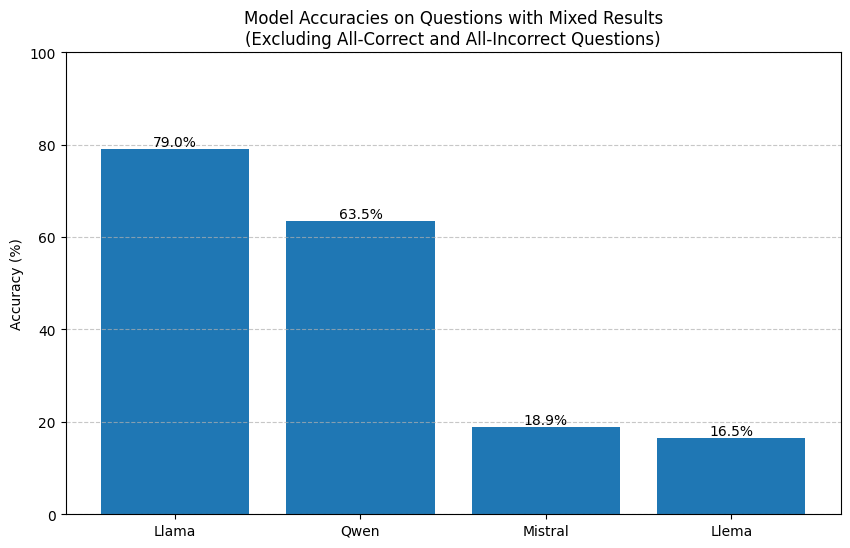

In [81]:
# Run the analysis
results_df, plot = analyze_model_accuracies_mixed_results(all_results)

# Display the results
print("\nDetailed accuracy statistics:")
display(results_df)
plot.show()